In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2

from tensorflow import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

C:\Users\yseon\Anaconda3\envs\bengali\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\yseon\Anaconda3\envs\bengali\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\yseon\Anaconda3\envs\bengali\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\yseon\Anaconda3\envs\bengali\lib\site-packages\tensorflow\

In [2]:
train_df_ = pd.read_csv('bengaliai-cv19/train.csv')
test_df_ = pd.read_csv('bengaliai-cv19/test.csv')
class_map_df = pd.read_csv('bengaliai-cv19/class_map.csv')
sample_sub_df = pd.read_csv('bengaliai-cv19/sample_submission.csv')

In [3]:
train_df_.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [4]:
test_df_.head()

,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


In [5]:
print(class_map_df.head())
class_map_df['component_type'].value_counts()

  component_type  label component
0  grapheme_root      0         ং
1  grapheme_root      1         ঃ
2  grapheme_root      2         অ
3  grapheme_root      3         আ
4  grapheme_root      4         ই


grapheme_root          168
vowel_diacritic         11
consonant_diacritic      7
Name: component_type, dtype: int64

In [6]:
class_map_df[class_map_df['label']==9]

,component_type,label,component
9,grapheme_root,9,এ
177,vowel_diacritic,9,ো


In [7]:
train_df_.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


## EDA

In [8]:
HEIGHT = 236
WIDTH = 236

# def get_n(df, field, n, top = True):
    

In [9]:
HEIGHT = 236
WIDTH = 236

def get_n(df, field, n, top=True):
    top_graphemes = df.groupby([field]).size().reset_index(name='counts')['counts'].sort_values(ascending=not top)[:n]
    top_grapheme_roots = top_graphemes.index
    top_grapheme_counts = top_graphemes.values
    top_graphemes = class_map_df[class_map_df['component_type'] == field].reset_index().iloc[top_grapheme_roots]
    top_graphemes.drop(['component_type', 'label'], axis=1, inplace=True)
    top_graphemes.loc[:, 'count'] = top_grapheme_counts
    return top_graphemes

def image_from_char(char):
    image = Image.new('RGB', (WIDTH, HEIGHT))
    draw = ImageDraw.Draw(image)
    myfont = ImageFont.truetype('bengaliai-cv19/kalpurush-2.ttf', 120)
    w, h = draw.textsize(char, font=myfont)
    draw.text(((WIDTH - w) / 2,(HEIGHT - h) / 3), char, font=myfont)

    return image

     index component  count
72      72         দ   5736
64      64         ত   5596
13      13         ক   5420
107    107         ব   5321
23      23         গ   5149
96      96         প   4926
113    113         ভ   4395
147    147         স   4392
133    133         শ   4374
115    115         ম   4015


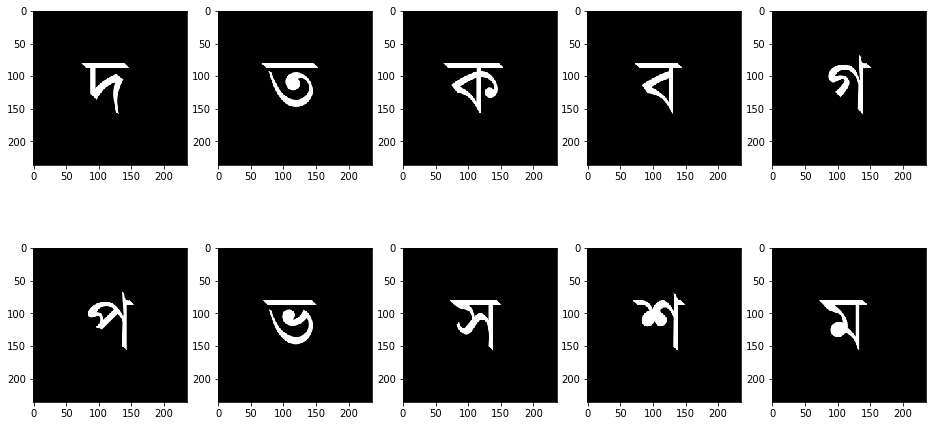

In [10]:
# Grapheme_root
top_10_roots = get_n(train_df_, 'grapheme_root', 10)
print(top_10_roots)

f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].imshow(image_from_char(top_10_roots['component'].iloc[i]), cmap='Greys')

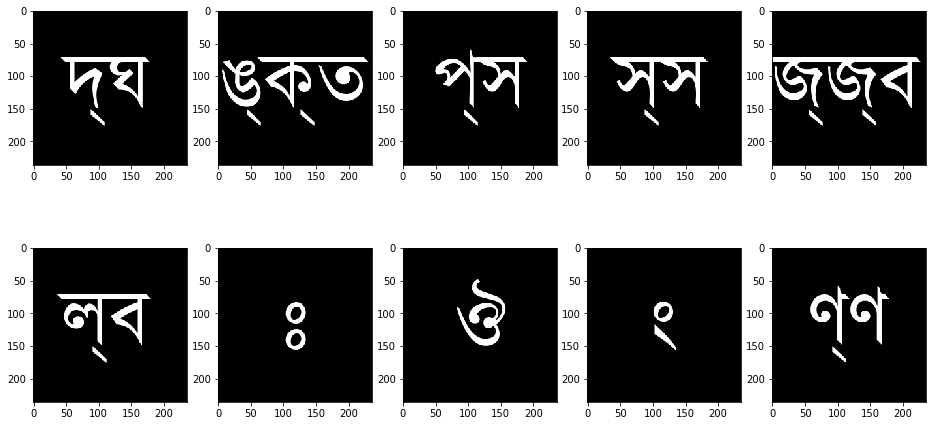

In [11]:
bottom_10_roots = get_n(train_df_, 'grapheme_root', 10, False)
bottom_10_roots
f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].imshow(image_from_char(bottom_10_roots['component'].iloc[i]), cmap='Greys')

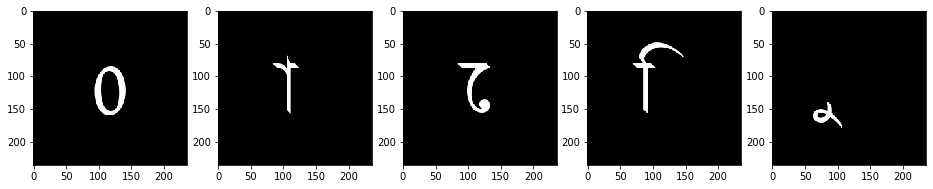

In [12]:
top_5_vowels = get_n(train_df_, 'vowel_diacritic', 5)
top_5_vowels
f, ax = plt.subplots(1, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(5):
    ax[i].imshow(image_from_char(top_5_vowels['component'].iloc[i]), cmap='Greys')

In [13]:
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)

In [14]:
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [15]:
IMG_SIZE=64
N_CHANNELS = 1

In [16]:
# Image Processing while resizing the images, 
# center crop
def resize(df, size=64, need_progress_bar=True):
    resized = {}
    resize_size=64
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    else:
        for i in range(df.shape[0]):
            #image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size),None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

In [17]:
def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

In [18]:
IMG_SIZE

64

## Crop


In [19]:
# #https://www.kaggle.com/iafoss/image-preprocessing-128x128
# HEIGHT = 137 
# WIDTH = 236
# def bbox(img):
#     rows = np.any(img, axis=1)
#     cols = np.any(img, axis=0)
#     rmin, rmax = np.where(rows)[0][[0, -1]]
#     cmin, cmax = np.where(cols)[0][[0, -1]]
#     return rmin, rmax, cmin, cmax

# def crop_resize(img0, size=IMG_SIZE, pad=16):
#     #crop a box around pixels large than the threshold 
#     #some images contain line at the sides
#     ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
#     #cropping may cut too much, so we need to add it back
#     xmin = xmin - 13 if (xmin > 13) else 0
#     ymin = ymin - 10 if (ymin > 10) else 0
#     xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
#     ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
#     img = img0[ymin:ymax,xmin:xmax]
#     #remove lo intensity pixels as noise
#     img[img < 28] = 0
#     lx, ly = xmax-xmin,ymax-ymin
#     l = max(lx,ly) + pad
#     #make sure that the aspect ratio is kept in rescaling
#     img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
#     return cv2.resize(img,(size,size))

### Augmix

In [20]:
# https://www.kaggle.com/haqishen/augmix-based-on-albumentations
from PIL import Image, ImageOps, ImageEnhance
def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.


def sample_level(n):
    return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
    return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

def normalize(image):
    """Normalize input image channel-wise to zero mean and unit variance."""
    return image - 127

def apply_op(image, op, severity):
    #   image = np.clip(image, 0, 255)
    pil_img = Image.fromarray(image)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)
    return np.asarray(pil_img)

def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1.):
    """Perform AugMix augmentations and compute mixture.
    Args:
    image: Raw input image as float32 np.ndarray of shape (h, w, c)
    severity: Severity of underlying augmentation operators (between 1 to 10).
    width: Width of augmentation chain
    depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
      from [1, 3]
    alpha: Probability coefficient for Beta and Dirichlet distributions.
    Returns:
    mixed: Augmented and mixed image.
    """
    ws = np.float32(
      np.random.dirichlet([alpha] * width))
    m = np.float32(np.random.beta(alpha, alpha))

    mix = np.zeros_like(image).astype(np.float32)
    for i in range(width):
        image_aug = image.copy()
        depth = depth if depth > 0 else np.random.randint(1, 4)
        for _ in range(depth):
            op = np.random.choice(augmentations)
            image_aug = apply_op(image_aug, op, severity)
        # Preprocessing commutes since all coefficients are convex
        mix += ws[i] * image_aug
#         mix += ws[i] * normalize(image_aug)

    mixed = (1 - m) * image + m * mix
#     mixed = (1 - m) * normalize(image) + m * mix
    return mixed


In [21]:
# https://www.kaggle.com/virajbagal/fast-ai-mixup-cutmix-augmix-and-gridmask-visuals
# def cutout(x, n_holes:uniform_int=1, length:uniform_int=40):
#     "Cut out `n_holes` number of square holes of size `length` in image at random locations."
#     h,w = x.shape[1:]
#     for n in range(n_holes):
#         h_y = np.random.randint(0, h)
#         h_x = np.random.randint(0, w)
#         y1 = int(np.clip(h_y - length / 2, 0, h))
#         y2 = int(np.clip(h_y + length / 2, 0, h))
#         x1 = int(np.clip(h_x - length / 2, 0, w))
#         x2 = int(np.clip(h_x + length / 2, 0, w))
#         x[:, y1:y2, x1:x2] = 1
#     return x

In [22]:
# df = pd.read_parquet(f'bengaliai-cv19/train_image_data_0.parquet')
# n_imgs = 8
# fig, axs = plt.subplots(n_imgs, 2, figsize=(10, 5*n_imgs))

# for idx in range(n_imgs):
#     #somehow the original input is inverted
#     img0 = 255 - df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
#     #normalize each image by its max val
#     img = (img0*(255.0/img0.max())).astype(np.uint8)
#     img = crop_resize(img)
    
#     img = augment_and_mix(img)
    
#     axs[idx,0].imshow(img0)
#     axs[idx,0].set_title('Original image')
#     axs[idx,0].axis('off')
#     axs[idx,1].imshow(img)
#     axs[idx,1].set_title('Crop & resize')
#     axs[idx,1].axis('off')
# plt.show()

# Basic Model

In [23]:
# inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

# model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
# model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = BatchNormalization(momentum=0.15)(model)
# model = MaxPool2D(pool_size=(2, 2))(model)
# model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
# model = Dropout(rate=0.3)(model)

# model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = BatchNormalization(momentum=0.15)(model)
# model = MaxPool2D(pool_size=(2, 2))(model)
# model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
# model = BatchNormalization(momentum=0.15)(model)
# model = Dropout(rate=0.3)(model)

# model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = BatchNormalization(momentum=0.15)(model)
# model = MaxPool2D(pool_size=(2, 2))(model)
# model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
# model = BatchNormalization(momentum=0.15)(model)
# model = Dropout(rate=0.3)(model)

# model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = BatchNormalization(momentum=0.15)(model)
# model = MaxPool2D(pool_size=(2, 2))(model)
# model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
# model = BatchNormalization(momentum=0.15)(model)
# model = Dropout(rate=0.3)(model)

# model = Flatten()(model)
# model = Dense(1024, activation = "relu")(model)
# model = Dropout(rate=0.3)(model)
# dense = Dense(512, activation = "relu")(model)

# head_root = Dense(168, activation = 'softmax')(dense)
# head_vowel = Dense(11, activation = 'softmax')(dense)
# head_consonant = Dense(7, activation = 'softmax')(dense)

# model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

In [24]:
from keras_applications.resnext import ResNeXt101
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121
from keras_efficientnets import EfficientNetB0
from keras import backend as K
from keras import layers, models, optimizers, utils, backend,regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D
from keras import layers, models, optimizers, utils, backend,regularizers
from keras.layers import LeakyReLU
def get_model(model_name='DenseNet121'):
#     inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))
#     resNet_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(128,128,3))
    resNet_model = ResNeXt101(include_top= False, input_shape = (64,64,3)
                            , backend =backend, layers=layers, models = models,
                             utils = utils
                            )
    
#     densenet = DenseNet121(weights='imagenet', include_top=False)

#     input = Input(shape=(SIZE, SIZE, N_ch))
#     x = Conv2D(3, (3, 3), padding='same')(input)
    
    inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))
    model = Conv2D(3, (3, 3), padding='same')(inputs)
    model = resNet_model(model)
    # resNet_model.summary()
    
#     model = Sequential()
#     model.add(resNet_model)
#     model.add(GlobalAveragePooling2D())
#     model.add(layers.Dropout(0.25))  # 과적합 줄여보기
#     model.add(Dense(196, activation='softmax', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l=0.01)))
#     #model.add(Dense(196, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l=0.01)))
#    # model.add(LeakyReLU(alpha=0.01))
    
#     model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
# model = BatchNormalization(momentum=0.15)(model)
# model = MaxPool2D(pool_size=(2, 2))(model)
# model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
# model = BatchNormalization(momentum=0.15)(model)
# model = Dropout(rate=0.3)(model)

#     model = resNet_model.layers[-1].output
    model = GlobalAveragePooling2D()(model)
    model = Dropout(rate=0.3)(model)
    
  #  model = Flatten()(model)
    model = Dense(1024, activation = "relu")(model)
    model = Dropout(rate=0.3)(model)
    dense = Dense(512, activation = "relu")(model)
    
    head_root = Dense(168, activation = 'softmax')(model)
    head_vowel = Dense(11, activation = 'softmax')(model)
    head_consonant = Dense(7, activation = 'softmax')(model)

    model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])
    
    model.summary()
    adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer = adam,loss = 'categorical_crossentropy', metrics=['accuracy'])
    # compile 할때 넣어줘야지 아래에서 early stopping 할때 사용 가능하다
    return model

In [25]:
model = get_model()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 3)    30          input_2[0][0]                    
__________________________________________________________________________________________________
resnext101 (Model)              (None, 2, 2, 2048)   42266560    conv2d_1[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           resnext101[1][0]                 
___________________________________________________________________________________________

In [26]:
# from keras.utils import plot_model
# plot_model(model, to_file='model.png')

In [27]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
from keras.callbacks import  EarlyStopping
learning_rate_reduction_root = ReduceLROnPlateau(monitor='dense_3_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='dense_4_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='dense_5_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
# Callback : Early Stop
earlyStop = EarlyStopping(monitor='val_loss',
                          mode = 'min',
                          patience = 4,
                          min_delta = 0,
                          verbose = 1)

In [36]:
batch_size = 100
epochs = 100

In [30]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=200,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

In [31]:
HEIGHT = 137
WIDTH = 236

In [32]:
# # from tensorflow.python.client import device_lib

# # print(device_lib.list_local_devices())

# from keras import backend as K

# K.tensorflow_backend._get_available_gpus()



In [33]:
# from keras.backend.tensorflow_backend import set_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import get_session
# import tensorflow

# # Reset Keras Session
# def reset_keras():
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

#     try:
#         del classifier # this is from global space - change this as you need
#     except:
#         pass

#     print(gc.collect()) # if it's done something you should see a number being outputted

#     # use the same config as you used to create the session
#     config = tensorflow.ConfigProto()
#     config.gpu_options.per_process_gpu_memory_fraction = 1
#     config.gpu_options.visible_device_list = "0"
#     set_session(tensorflow.Session(config=config))
# reset_keras()

In [34]:
# ## LIMIT GPU USAGE
# import tensorflow as tf
# from keras import backend as K
# config = tf.ConfigProto()  
# config.gpu_options.allow_growth = True  # don't pre-allocate memory; allocate as-needed
# config.gpu_options.per_process_gpu_memory_fraction = 0.95  # limit memory to be allocated
# K.tensorflow_backend.set_session(tf.Session(config=config)) # create sess w/ above settings

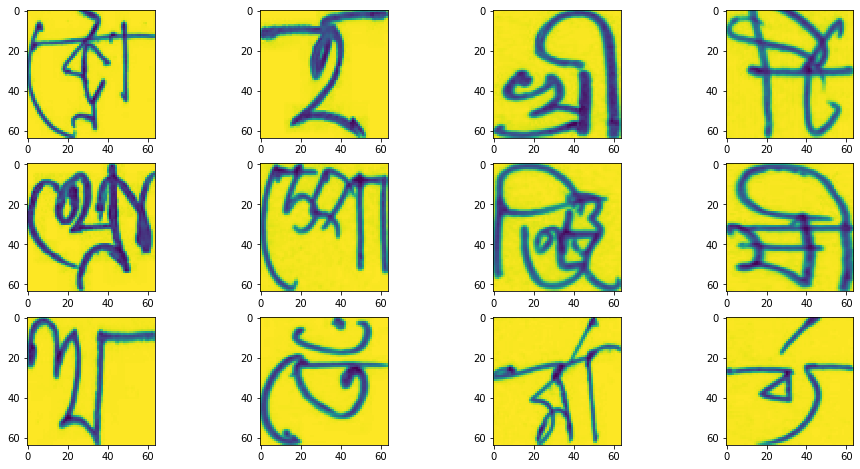


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/100
461/461 [==============================] - 206s 447ms/step - loss: 6.6339 - dense_3_loss: 4.4056 - dense_4_loss: 1.3237 - dense_5_loss: 0.9046 - dense_3_accuracy: 0.0796 - dense_4_accuracy: 0.5533 - dense_5_accuracy: 0.7046 - val_loss: 4.3339 - val_dense_3_loss: 3.2565 - val_dense_4_loss: 0.5760 - val_dense_5_loss: 0.4973 - val_dense_3_accuracy: 0.2365 - val_dense_4_accuracy: 0.8086 - val_dense_5_accuracy: 0.8389
Epoch 2/100
461/461 [==============================] - 204s 442ms/step - loss: 4.2269 - dense_3_loss: 2.8031 - dense_4_loss: 0.8447 - dense_5_loss: 0.5791 - dense_3_accuracy: 0.3255 - dense_4_accuracy: 0.7200 - dense_5_accuracy: 0.8118 - val_loss: 2.0077 - val_dense_3_loss: 1.4010 - val_dense_4_loss: 0.3644 - val_dense_5_loss: 0.2399 - val_dense_3_accuracy: 0.6107 - val_dense_4_accuracy: 0.8860 - val_dense_5_accuracy: 0.9

Epoch 20/100
461/461 [==============================] - 202s 438ms/step - loss: 0.9425 - dense_3_loss: 0.4795 - dense_4_loss: 0.2724 - dense_5_loss: 0.1907 - dense_3_accuracy: 0.8626 - dense_4_accuracy: 0.9122 - dense_5_accuracy: 0.9371 - val_loss: 0.5150 - val_dense_3_loss: 0.3156 - val_dense_4_loss: 0.1121 - val_dense_5_loss: 0.1009 - val_dense_3_accuracy: 0.9159 - val_dense_4_accuracy: 0.9736 - val_dense_5_accuracy: 0.9709
Epoch 21/100
461/461 [==============================] - 202s 438ms/step - loss: 0.9090 - dense_3_loss: 0.4556 - dense_4_loss: 0.2729 - dense_5_loss: 0.1805 - dense_3_accuracy: 0.8691 - dense_4_accuracy: 0.9117 - dense_5_accuracy: 0.9402 - val_loss: 0.5957 - val_dense_3_loss: 0.3326 - val_dense_4_loss: 0.1766 - val_dense_5_loss: 0.1004 - val_dense_3_accuracy: 0.9206 - val_dense_4_accuracy: 0.9447 - val_dense_5_accuracy: 0.9726
Epoch 22/100
461/461 [==============================] - 202s 438ms/step - loss: 0.8817 - dense_3_loss: 0.4469 - dense_4_loss: 0.2586 - dense

Epoch 39/100
461/461 [==============================] - 202s 437ms/step - loss: 0.5226 - dense_3_loss: 0.2462 - dense_4_loss: 0.1658 - dense_5_loss: 0.1106 - dense_3_accuracy: 0.9262 - dense_4_accuracy: 0.9446 - dense_5_accuracy: 0.9619 - val_loss: 0.4450 - val_dense_3_loss: 0.2985 - val_dense_4_loss: 0.0964 - val_dense_5_loss: 0.0765 - val_dense_3_accuracy: 0.9353 - val_dense_4_accuracy: 0.9766 - val_dense_5_accuracy: 0.9801
Epoch 40/100
461/461 [==============================] - 202s 437ms/step - loss: 0.5061 - dense_3_loss: 0.2375 - dense_4_loss: 0.1623 - dense_5_loss: 0.1063 - dense_3_accuracy: 0.9289 - dense_4_accuracy: 0.9458 - dense_5_accuracy: 0.9637 - val_loss: 0.4238 - val_dense_3_loss: 0.2819 - val_dense_4_loss: 0.0846 - val_dense_5_loss: 0.0766 - val_dense_3_accuracy: 0.9340 - val_dense_4_accuracy: 0.9821 - val_dense_5_accuracy: 0.9788
Epoch 41/100
461/461 [==============================] - 202s 438ms/step - loss: 0.5065 - dense_3_loss: 0.2332 - dense_4_loss: 0.1632 - dense

Epoch 58/100
461/461 [==============================] - 202s 437ms/step - loss: 0.3527 - dense_3_loss: 0.1536 - dense_4_loss: 0.1213 - dense_5_loss: 0.0778 - dense_3_accuracy: 0.9535 - dense_4_accuracy: 0.9581 - dense_5_accuracy: 0.9728 - val_loss: 0.4852 - val_dense_3_loss: 0.3107 - val_dense_4_loss: 0.1114 - val_dense_5_loss: 0.0782 - val_dense_3_accuracy: 0.9335 - val_dense_4_accuracy: 0.9731 - val_dense_5_accuracy: 0.9764
Epoch 59/100
461/461 [==============================] - 202s 438ms/step - loss: 0.3483 - dense_3_loss: 0.1518 - dense_4_loss: 0.1198 - dense_5_loss: 0.0768 - dense_3_accuracy: 0.9530 - dense_4_accuracy: 0.9597 - dense_5_accuracy: 0.9737 - val_loss: 0.4872 - val_dense_3_loss: 0.3412 - val_dense_4_loss: 0.0990 - val_dense_5_loss: 0.0720 - val_dense_3_accuracy: 0.9335 - val_dense_4_accuracy: 0.9786 - val_dense_5_accuracy: 0.9811
Epoch 60/100
461/461 [==============================] - 202s 438ms/step - loss: 0.3465 - dense_3_loss: 0.1521 - dense_4_loss: 0.1186 - dense

Epoch 77/100
461/461 [==============================] - 202s 437ms/step - loss: 0.2730 - dense_3_loss: 0.1159 - dense_4_loss: 0.0948 - dense_5_loss: 0.0623 - dense_3_accuracy: 0.9641 - dense_4_accuracy: 0.9662 - dense_5_accuracy: 0.9783 - val_loss: 0.5045 - val_dense_3_loss: 0.3407 - val_dense_4_loss: 0.1124 - val_dense_5_loss: 0.0716 - val_dense_3_accuracy: 0.9363 - val_dense_4_accuracy: 0.9724 - val_dense_5_accuracy: 0.9803
Epoch 78/100
461/461 [==============================] - 202s 437ms/step - loss: 0.2687 - dense_3_loss: 0.1115 - dense_4_loss: 0.0984 - dense_5_loss: 0.0587 - dense_3_accuracy: 0.9658 - dense_4_accuracy: 0.9660 - dense_5_accuracy: 0.9795 - val_loss: 0.4907 - val_dense_3_loss: 0.3492 - val_dense_4_loss: 0.0981 - val_dense_5_loss: 0.0700 - val_dense_3_accuracy: 0.9348 - val_dense_4_accuracy: 0.9808 - val_dense_5_accuracy: 0.9816
Epoch 79/100
461/461 [==============================] - 202s 438ms/step - loss: 0.2663 - dense_3_loss: 0.1158 - dense_4_loss: 0.0930 - dense

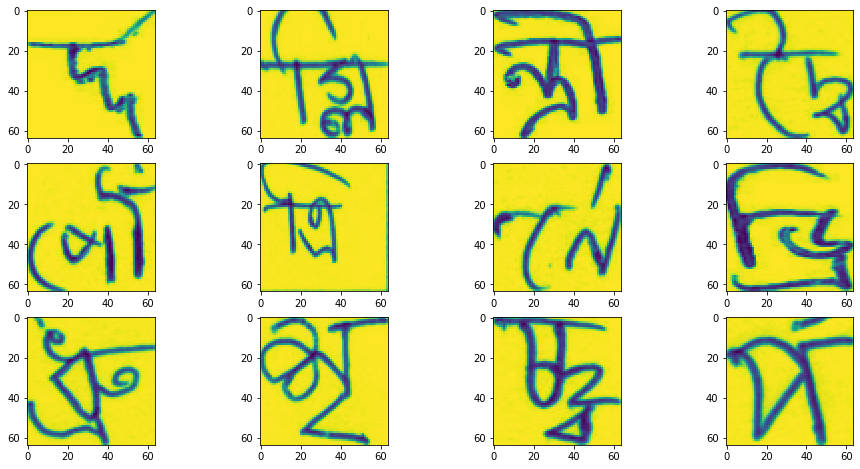


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/100
461/461 [==============================] - 202s 438ms/step - loss: 0.9016 - dense_3_loss: 0.5008 - dense_4_loss: 0.2308 - dense_5_loss: 0.1701 - dense_3_accuracy: 0.8733 - dense_4_accuracy: 0.9293 - dense_5_accuracy: 0.9465 - val_loss: 0.4197 - val_dense_3_loss: 0.2375 - val_dense_4_loss: 0.0857 - val_dense_5_loss: 0.0883 - val_dense_3_accuracy: 0.9442 - val_dense_4_accuracy: 0.9788 - val_dense_5_accuracy: 0.9776
Epoch 2/100
461/461 [==============================] - 202s 439ms/step - loss: 0.7832 - dense_3_loss: 0.4234 - dense_4_loss: 0.2083 - dense_5_loss: 0.1515 - dense_3_accuracy: 0.8829 - dense_4_accuracy: 0.9323 - dense_5_accuracy: 0.9501 - val_loss: 0.3788 - val_dense_3_loss: 0.2124 - val_dense_4_loss: 0.0795 - val_dense_5_loss: 0.0796 - val_dense_3_accuracy: 0.9465 - val_dense_4_accuracy: 0.9791 - val_dense_5_accuracy: 0.9

Epoch 20/100
461/461 [==============================] - 202s 438ms/step - loss: 0.5381 - dense_3_loss: 0.2645 - dense_4_loss: 0.1633 - dense_5_loss: 0.1103 - dense_3_accuracy: 0.9200 - dense_4_accuracy: 0.9453 - dense_5_accuracy: 0.9620 - val_loss: 0.3542 - val_dense_3_loss: 0.1982 - val_dense_4_loss: 0.0686 - val_dense_5_loss: 0.0806 - val_dense_3_accuracy: 0.9485 - val_dense_4_accuracy: 0.9821 - val_dense_5_accuracy: 0.9796
Epoch 21/100
461/461 [==============================] - 202s 437ms/step - loss: 0.5394 - dense_3_loss: 0.2707 - dense_4_loss: 0.1583 - dense_5_loss: 0.1104 - dense_3_accuracy: 0.9201 - dense_4_accuracy: 0.9467 - dense_5_accuracy: 0.9629 - val_loss: 0.3575 - val_dense_3_loss: 0.1977 - val_dense_4_loss: 0.0706 - val_dense_5_loss: 0.0823 - val_dense_3_accuracy: 0.9487 - val_dense_4_accuracy: 0.9801 - val_dense_5_accuracy: 0.9788
Epoch 22/100
461/461 [==============================] - 202s 438ms/step - loss: 0.5240 - dense_3_loss: 0.2587 - dense_4_loss: 0.1550 - dense

461/461 [==============================] - 202s 439ms/step - loss: 0.3724 - dense_3_loss: 0.1724 - dense_4_loss: 0.1215 - dense_5_loss: 0.0785 - dense_3_accuracy: 0.9467 - dense_4_accuracy: 0.9572 - dense_5_accuracy: 0.9725 - val_loss: 0.4124 - val_dense_3_loss: 0.2309 - val_dense_4_loss: 0.0785 - val_dense_5_loss: 0.0950 - val_dense_3_accuracy: 0.9500 - val_dense_4_accuracy: 0.9808 - val_dense_5_accuracy: 0.9793
Epoch 59/100
461/461 [==============================] - 202s 438ms/step - loss: 0.3792 - dense_3_loss: 0.1756 - dense_4_loss: 0.1230 - dense_5_loss: 0.0806 - dense_3_accuracy: 0.9467 - dense_4_accuracy: 0.9576 - dense_5_accuracy: 0.9714 - val_loss: 0.4193 - val_dense_3_loss: 0.2314 - val_dense_4_loss: 0.0851 - val_dense_5_loss: 0.0945 - val_dense_3_accuracy: 0.9510 - val_dense_4_accuracy: 0.9791 - val_dense_5_accuracy: 0.9801
Epoch 60/100
461/461 [==============================] - 202s 438ms/step - loss: 0.3750 - dense_3_loss: 0.1742 - dense_4_loss: 0.1205 - dense_5_loss: 0.08

461/461 [==============================] - 202s 438ms/step - loss: 0.2992 - dense_3_loss: 0.1338 - dense_4_loss: 0.1004 - dense_5_loss: 0.0649 - dense_3_accuracy: 0.9598 - dense_4_accuracy: 0.9653 - dense_5_accuracy: 0.9770 - val_loss: 0.4978 - val_dense_3_loss: 0.2836 - val_dense_4_loss: 0.0968 - val_dense_5_loss: 0.1087 - val_dense_3_accuracy: 0.9435 - val_dense_4_accuracy: 0.9776 - val_dense_5_accuracy: 0.9783
Epoch 97/100
461/461 [==============================] - 203s 441ms/step - loss: 0.2999 - dense_3_loss: 0.1306 - dense_4_loss: 0.1030 - dense_5_loss: 0.0663 - dense_3_accuracy: 0.9605 - dense_4_accuracy: 0.9636 - dense_5_accuracy: 0.9765 - val_loss: 0.5111 - val_dense_3_loss: 0.2942 - val_dense_4_loss: 0.0988 - val_dense_5_loss: 0.1082 - val_dense_3_accuracy: 0.9440 - val_dense_4_accuracy: 0.9781 - val_dense_5_accuracy: 0.9791
Epoch 98/100
461/461 [==============================] - 204s 442ms/step - loss: 0.3007 - dense_3_loss: 0.1341 - dense_4_loss: 0.1000 - dense_5_loss: 0.06

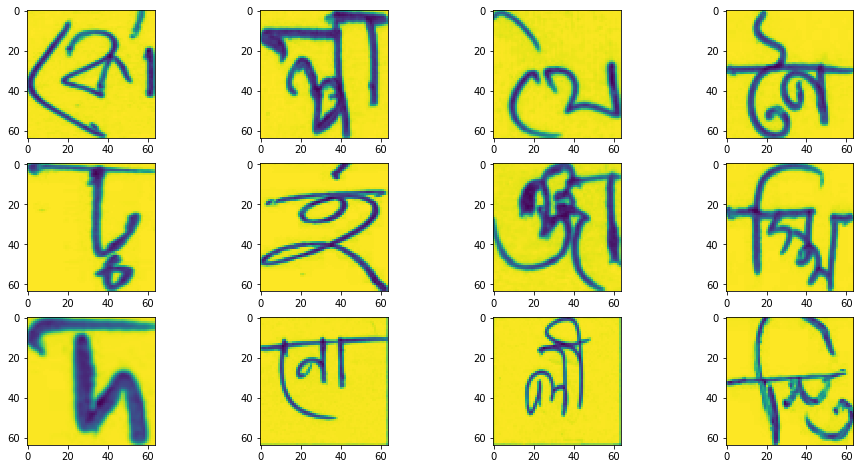


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/100
461/461 [==============================] - 204s 442ms/step - loss: 0.7730 - dense_3_loss: 0.4173 - dense_4_loss: 0.2022 - dense_5_loss: 0.1535 - dense_3_accuracy: 0.8917 - dense_4_accuracy: 0.9362 - dense_5_accuracy: 0.9520 - val_loss: 0.3651 - val_dense_3_loss: 0.2234 - val_dense_4_loss: 0.0705 - val_dense_5_loss: 0.0709 - val_dense_3_accuracy: 0.9462 - val_dense_4_accuracy: 0.9831 - val_dense_5_accuracy: 0.9793
Epoch 2/100
461/461 [==============================] - 204s 442ms/step - loss: 0.6882 - dense_3_loss: 0.3677 - dense_4_loss: 0.1842 - dense_5_loss: 0.1364 - dense_3_accuracy: 0.8961 - dense_4_accuracy: 0.9396 - dense_5_accuracy: 0.9552 - val_loss: 0.3440 - val_dense_3_loss: 0.2022 - val_dense_4_loss: 0.0725 - val_dense_5_loss: 0.0687 - val_dense_3_accuracy: 0.9457 - val_dense_4_accuracy: 0.9813 - val_dense_5_accuracy: 0.9

Epoch 20/100
461/461 [==============================] - 202s 438ms/step - loss: 0.4689 - dense_3_loss: 0.2319 - dense_4_loss: 0.1410 - dense_5_loss: 0.0960 - dense_3_accuracy: 0.9298 - dense_4_accuracy: 0.9518 - dense_5_accuracy: 0.9670 - val_loss: 0.3188 - val_dense_3_loss: 0.1798 - val_dense_4_loss: 0.0662 - val_dense_5_loss: 0.0698 - val_dense_3_accuracy: 0.9520 - val_dense_4_accuracy: 0.9836 - val_dense_5_accuracy: 0.9801
Epoch 21/100
461/461 [==============================] - 202s 439ms/step - loss: 0.4617 - dense_3_loss: 0.2228 - dense_4_loss: 0.1427 - dense_5_loss: 0.0962 - dense_3_accuracy: 0.9311 - dense_4_accuracy: 0.9524 - dense_5_accuracy: 0.9668 - val_loss: 0.3217 - val_dense_3_loss: 0.1893 - val_dense_4_loss: 0.0599 - val_dense_5_loss: 0.0674 - val_dense_3_accuracy: 0.9520 - val_dense_4_accuracy: 0.9856 - val_dense_5_accuracy: 0.9803
Epoch 22/100
461/461 [==============================] - 202s 438ms/step - loss: 0.4617 - dense_3_loss: 0.2244 - dense_4_loss: 0.1392 - dense

461/461 [==============================] - 202s 439ms/step - loss: 0.3317 - dense_3_loss: 0.1538 - dense_4_loss: 0.1071 - dense_5_loss: 0.0709 - dense_3_accuracy: 0.9527 - dense_4_accuracy: 0.9628 - dense_5_accuracy: 0.9753 - val_loss: 0.3908 - val_dense_3_loss: 0.2263 - val_dense_4_loss: 0.0731 - val_dense_5_loss: 0.0841 - val_dense_3_accuracy: 0.9520 - val_dense_4_accuracy: 0.9816 - val_dense_5_accuracy: 0.9778
Epoch 59/100
461/461 [==============================] - 202s 439ms/step - loss: 0.3333 - dense_3_loss: 0.1525 - dense_4_loss: 0.1085 - dense_5_loss: 0.0723 - dense_3_accuracy: 0.9517 - dense_4_accuracy: 0.9620 - dense_5_accuracy: 0.9744 - val_loss: 0.4136 - val_dense_3_loss: 0.2496 - val_dense_4_loss: 0.0710 - val_dense_5_loss: 0.0849 - val_dense_3_accuracy: 0.9477 - val_dense_4_accuracy: 0.9821 - val_dense_5_accuracy: 0.9791
Epoch 60/100
461/461 [==============================] - 202s 439ms/step - loss: 0.3280 - dense_3_loss: 0.1485 - dense_4_loss: 0.1098 - dense_5_loss: 0.06

461/461 [==============================] - 201s 437ms/step - loss: 0.2515 - dense_3_loss: 0.1114 - dense_4_loss: 0.0850 - dense_5_loss: 0.0551 - dense_3_accuracy: 0.9646 - dense_4_accuracy: 0.9693 - dense_5_accuracy: 0.9803 - val_loss: 0.4599 - val_dense_3_loss: 0.2781 - val_dense_4_loss: 0.0806 - val_dense_5_loss: 0.0932 - val_dense_3_accuracy: 0.9482 - val_dense_4_accuracy: 0.9808 - val_dense_5_accuracy: 0.9793
Epoch 97/100
461/461 [==============================] - 202s 438ms/step - loss: 0.2633 - dense_3_loss: 0.1146 - dense_4_loss: 0.0896 - dense_5_loss: 0.0591 - dense_3_accuracy: 0.9656 - dense_4_accuracy: 0.9688 - dense_5_accuracy: 0.9789 - val_loss: 0.4877 - val_dense_3_loss: 0.2877 - val_dense_4_loss: 0.0859 - val_dense_5_loss: 0.1053 - val_dense_3_accuracy: 0.9475 - val_dense_4_accuracy: 0.9786 - val_dense_5_accuracy: 0.9761
Epoch 98/100
461/461 [==============================] - 202s 438ms/step - loss: 0.2507 - dense_3_loss: 0.1108 - dense_4_loss: 0.0850 - dense_5_loss: 0.05

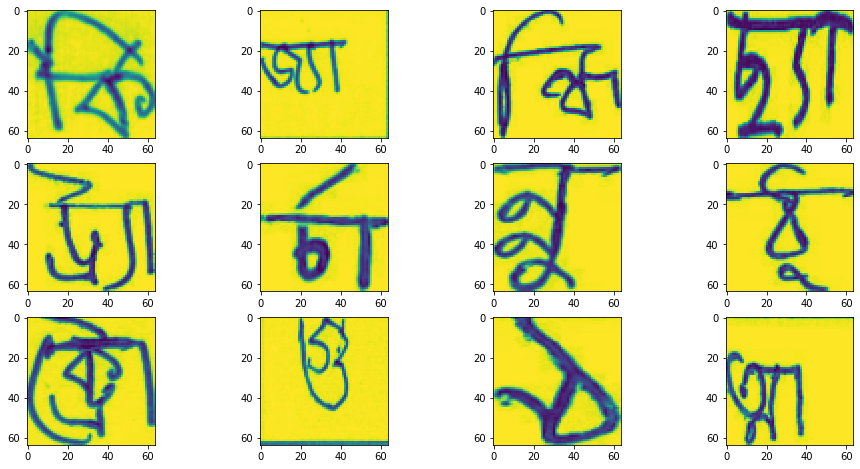


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/100
461/461 [==============================] - 201s 437ms/step - loss: 0.7267 - dense_3_loss: 0.3908 - dense_4_loss: 0.1936 - dense_5_loss: 0.1423 - dense_3_accuracy: 0.8985 - dense_4_accuracy: 0.9389 - dense_5_accuracy: 0.9550 - val_loss: 0.3562 - val_dense_3_loss: 0.2119 - val_dense_4_loss: 0.0787 - val_dense_5_loss: 0.0602 - val_dense_3_accuracy: 0.9482 - val_dense_4_accuracy: 0.9801 - val_dense_5_accuracy: 0.9836
Epoch 2/100
461/461 [==============================] - 202s 437ms/step - loss: 0.6428 - dense_3_loss: 0.3405 - dense_4_loss: 0.1761 - dense_5_loss: 0.1262 - dense_3_accuracy: 0.9042 - dense_4_accuracy: 0.9418 - dense_5_accuracy: 0.9585 - val_loss: 0.3243 - val_dense_3_loss: 0.1988 - val_dense_4_loss: 0.0686 - val_dense_5_loss: 0.0516 - val_dense_3_accuracy: 0.9492 - val_dense_4_accuracy: 0.9821 - val_dense_5_accuracy: 0.9

Epoch 20/100
461/461 [==============================] - 202s 438ms/step - loss: 0.4308 - dense_3_loss: 0.2062 - dense_4_loss: 0.1327 - dense_5_loss: 0.0919 - dense_3_accuracy: 0.9365 - dense_4_accuracy: 0.9549 - dense_5_accuracy: 0.9687 - val_loss: 0.3167 - val_dense_3_loss: 0.1992 - val_dense_4_loss: 0.0629 - val_dense_5_loss: 0.0485 - val_dense_3_accuracy: 0.9534 - val_dense_4_accuracy: 0.9848 - val_dense_5_accuracy: 0.9861
Epoch 21/100
461/461 [==============================] - 202s 438ms/step - loss: 0.4199 - dense_3_loss: 0.2023 - dense_4_loss: 0.1297 - dense_5_loss: 0.0878 - dense_3_accuracy: 0.9371 - dense_4_accuracy: 0.9547 - dense_5_accuracy: 0.9692 - val_loss: 0.3192 - val_dense_3_loss: 0.1996 - val_dense_4_loss: 0.0629 - val_dense_5_loss: 0.0506 - val_dense_3_accuracy: 0.9527 - val_dense_4_accuracy: 0.9843 - val_dense_5_accuracy: 0.9863
Epoch 22/100
461/461 [==============================] - 202s 438ms/step - loss: 0.4123 - dense_3_loss: 0.1986 - dense_4_loss: 0.1261 - dense

461/461 [==============================] - 202s 439ms/step - loss: 0.3004 - dense_3_loss: 0.1342 - dense_4_loss: 0.1015 - dense_5_loss: 0.0647 - dense_3_accuracy: 0.9572 - dense_4_accuracy: 0.9639 - dense_5_accuracy: 0.9767 - val_loss: 0.3859 - val_dense_3_loss: 0.2477 - val_dense_4_loss: 0.0725 - val_dense_5_loss: 0.0582 - val_dense_3_accuracy: 0.9527 - val_dense_4_accuracy: 0.9851 - val_dense_5_accuracy: 0.9856
Epoch 59/100
461/461 [==============================] - 202s 438ms/step - loss: 0.2995 - dense_3_loss: 0.1353 - dense_4_loss: 0.0997 - dense_5_loss: 0.0645 - dense_3_accuracy: 0.9571 - dense_4_accuracy: 0.9652 - dense_5_accuracy: 0.9770 - val_loss: 0.4089 - val_dense_3_loss: 0.2646 - val_dense_4_loss: 0.0743 - val_dense_5_loss: 0.0618 - val_dense_3_accuracy: 0.9500 - val_dense_4_accuracy: 0.9851 - val_dense_5_accuracy: 0.9851
Epoch 60/100
461/461 [==============================] - 202s 438ms/step - loss: 0.2874 - dense_3_loss: 0.1309 - dense_4_loss: 0.0936 - dense_5_loss: 0.06

461/461 [==============================] - 202s 438ms/step - loss: 0.2362 - dense_3_loss: 0.1025 - dense_4_loss: 0.0829 - dense_5_loss: 0.0507 - dense_3_accuracy: 0.9683 - dense_4_accuracy: 0.9703 - dense_5_accuracy: 0.9816 - val_loss: 0.4573 - val_dense_3_loss: 0.2943 - val_dense_4_loss: 0.0849 - val_dense_5_loss: 0.0694 - val_dense_3_accuracy: 0.9490 - val_dense_4_accuracy: 0.9826 - val_dense_5_accuracy: 0.9851
Epoch 97/100
461/461 [==============================] - 202s 438ms/step - loss: 0.2293 - dense_3_loss: 0.1000 - dense_4_loss: 0.0800 - dense_5_loss: 0.0492 - dense_3_accuracy: 0.9698 - dense_4_accuracy: 0.9713 - dense_5_accuracy: 0.9829 - val_loss: 0.4935 - val_dense_3_loss: 0.2978 - val_dense_4_loss: 0.1153 - val_dense_5_loss: 0.0725 - val_dense_3_accuracy: 0.9492 - val_dense_4_accuracy: 0.9741 - val_dense_5_accuracy: 0.9836
Epoch 98/100
461/461 [==============================] - 202s 438ms/step - loss: 0.2297 - dense_3_loss: 0.1004 - dense_4_loss: 0.0798 - dense_5_loss: 0.04

In [37]:
histories = []
for i in range(4):
    train_df = pd.merge(pd.read_parquet(f'bengaliai-cv19/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    
    # Visualize few samples of current training dataset
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count=0
    for row in ax:
        for col in row:
            col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(-1).reshape(IMG_SIZE, IMG_SIZE).astype(np.float64))
            count += 1
    plt.show()
    
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)

##################################################################################
        #somehow the original input is inverted
#     img0 = 255 -  X_train.iloc[:, 0:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
    #normalize each image by its max val
#     img = (img0*(255.0/img0.max())).astype(np.uint8)

#     X_train = crop_resize(X_train)/255 #resize(X_train)/255

    X_train = resize(X_train)/255
#     X_train = augment_and_mix(X_train)
#########################################################################


#     print("complete")
#     continue
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
 #########################################################################
    # Augmix
#     tst2 = []
#     for i in tqdm(range(X_train.shape[0])):
#         tst = augment_and_mix(X_train[0].reshape(IMG_SIZE,IMG_SIZE).astype(np.uint8))
#         tst2.append( tst.reshape(-1))#.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
#     X_train =np.array(tst2).reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS).astype(np.uint8)
    
    #########################################################################
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.25, # Randomly zoom image 
        width_shift_range=0.25,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.25,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

    # Fit the model
    history = model.fit_generator(datagen.flow(x_train, {'dense_3': y_train_root, 'dense_4': y_train_vowel, 'dense_5': y_train_consonant}, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant])

    histories.append(history)
    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()

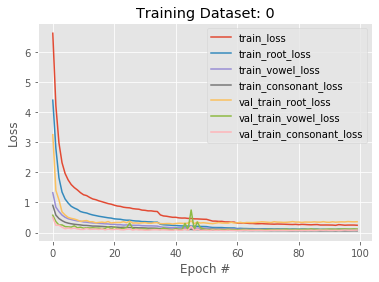

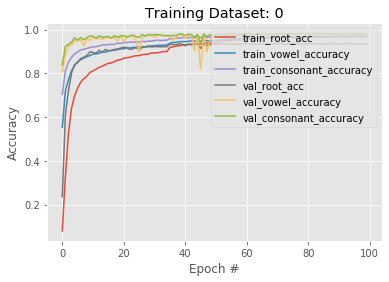

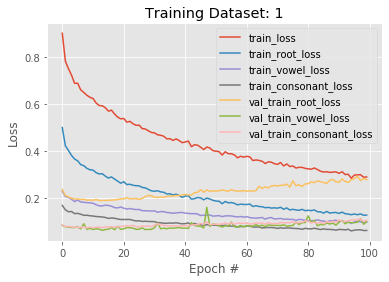

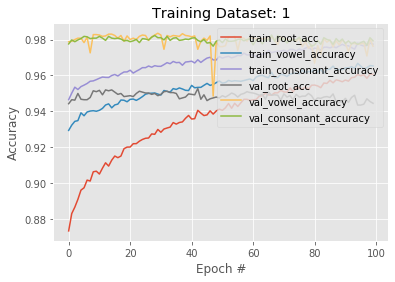

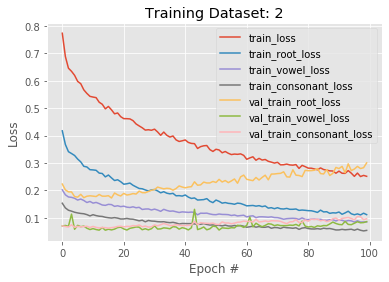

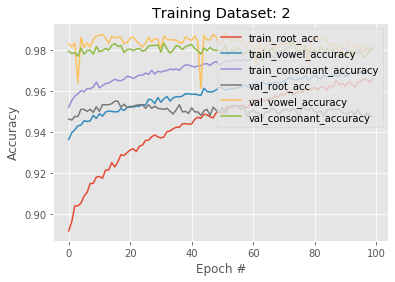

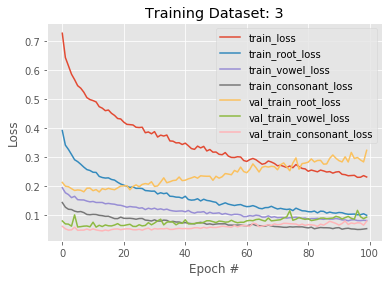

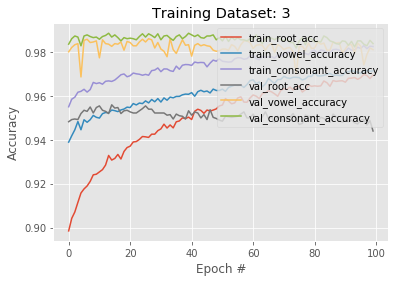

In [38]:
%matplotlib inline
def plot_loss(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_3_loss'], label='train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_4_loss'], label='train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_5_loss'], label='train_consonant_loss')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_loss'], label='val_train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_4_loss'], label='val_train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_5_loss'], label='val_train_consonant_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['dense_3_accuracy'], label='train_root_acc')
    plt.plot(np.arange(0, epoch), his.history['dense_4_accuracy'], label='train_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['dense_5_accuracy'], label='train_consonant_accuracy')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_accuracy'], label='val_root_acc')
    plt.plot(np.arange(0, epoch), his.history['val_dense_4_accuracy'], label='val_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['val_dense_5_accuracy'], label='val_consonant_accuracy')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()
for dataset in range(4):
    plot_loss(histories[dataset], epochs, f'Training Dataset: {dataset}')
    plot_acc(histories[dataset], epochs, f'Training Dataset: {dataset}')

In [39]:
del histories
gc.collect()

29261

In [41]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [42]:
# Save the model
model.save('dense121_model6_64.h5')

In [ ]:
# # serialize model to JSON
# model_json = model.to_json()
# with open("dense_model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("dense_model.h5")
# print("Saved model to disk")

In [ ]:
# from keras.models import model_from_json
# # load json and create model
# json_file = open('keras_model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("keras_model.h5")
# print("Loaded model from disk")

In [ ]:
# components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
# target=[] # model predictions placeholder
# row_id=[] # row_id place holder
# for i in range(4):
#     df_test_img = pd.read_parquet('/kaggle/input/bengaliai-cv19/test_image_data_{}.parquet'.format(i)) 
#     df_test_img.set_index('image_id', inplace=True)

#     X_test = resize(df_test_img, need_progress_bar=False)/255
#     X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
#     preds = model.predict(X_test)

#     for i, p in enumerate(preds_dict):
#         preds_dict[p] = np.argmax(preds[i], axis=1)

#     for k,id in enumerate(df_test_img.index.values):  
#         for i,comp in enumerate(components):
#             id_sample=id+'_'+comp
#             row_id.append(id_sample)
#             target.append(preds_dict[comp][k])
#     del df_test_img
#     del X_test
#     gc.collect()

# df_sample = pd.DataFrame(
#     {
#         'row_id': row_id,
#         'target':target
#     },
#     columns = ['row_id','target'] 
# )
# df_sample.to_csv('submission.csv',index=False)
# df_sample.head()